# Import module and prepare function

In [1]:
# import module

from PIL import Image, ImageDraw
import numpy as np
from matplotlib import pyplot as plt
import cv2
import face_recognition

In [2]:
# @desc: 算眉毛中心點座標的函數
# @input: 眉毛特徵座標list
# @return: 眉毛最左最右點的平均座標點(tuple)

def middle_of_eyebrow(eyebrow_landmarks):
    first_x_point = eyebrow_landmarks[0][0]
    last_x_point = eyebrow_landmarks[-1][0]
    first_y_point = eyebrow_landmarks[0][1]
    last_y_point = eyebrow_landmarks[-1][1]
    avg_point = ((first_x_point+last_x_point)/2, (first_y_point+last_y_point)/2)
    return avg_point

In [3]:
# @desc: 將座標轉換成可以畫圓的座標
# @input: 一組座標點(tuple)
# @return: 一組可以畫圓的座標點(tuple)

def transform_2_point(tuple_point):
    l = list(tuple_point)
    l.append(l[0]+5)
    l.append(l[1]+5)
    t = tuple(l)
    return t

# Process image

ex, ey, ew, eh: (88, 121, 60, 60)


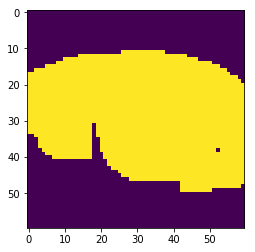

4 points:  (59, 49) (0, 49) (59, 11) (0, 11)
top_point_axis: (240, 282)


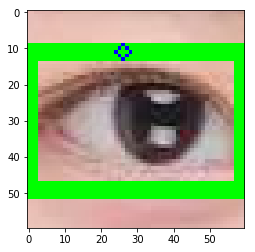

ex, ey, ew, eh: (235, 123, 60, 60)


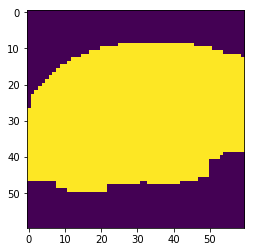

4 points:  (59, 49) (0, 49) (59, 9) (0, 9)
top_point_axis: (386, 282)


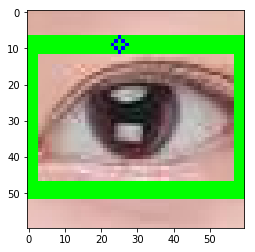

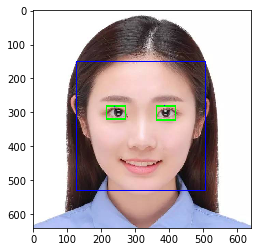

In [90]:
# process eye & eyelid

face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_eye.xml')

img = cv2.imread('images/1.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

faces = face_cascade.detectMultiScale(gray, 1.3, 5)
for (x,y,w,h) in faces:
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray, 3, 5)
    
    for (ex, ey, ew, eh) in eyes:
        print('ex, ey, ew, eh:', (ex, ey, ew, eh))
        crop_img = roi_color[ey:ey+eh, ex:ex+ew]
        eye_gray = cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY)
        
        # sharpen the image
        # bad...
        # kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]]) # sharpen kernel
        # img_sharpen = cv2.filter2D(eye_gray, -1, kernel)

        # find edge
        edges = cv2.Canny(eye_gray, 100, 200)
        
        # dilation
        closed = cv2.dilate(edges, None, iterations=4)
        plt.imshow(closed)
        plt.show()
        
        # find counter
        _, contours, hierarchy = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # find eyelid counter's axis
        max_x = 0
        min_x = 5000
        max_y = 0
        min_y = 5000
        top_point_x = 0
        top_point_y = 0
        for point in contours[-1]:
            # find max & min x-axis
            if point[0][0] > max_x:
                max_x = point[0][0]

            if point[0][0] < min_x:
                min_x = point[0][0]

            # find max & min y-axis
            if point[0][1] > max_y:
                max_y = point[0][1]

            if point[0][1] < min_y:
                min_y = point[0][1]
                top_point_y = point[0][1]
                top_point_x = point[0][0]
                
        top_right = (max_x, max_y)
        top_left = (min_x, max_y)
        bottom_right = (max_x, min_y)
        bottom_left = (min_x, min_y)
        
        print('4 points: ', top_right, top_left, bottom_right, bottom_left)
        print('top_point_axis:', (x+ex+top_point_x, y+ey+top_point_y))
        
        # draw counter on the image
        cv2.rectangle(crop_img, top_left, bottom_right, (0,255,0), 3)
        
        # draw top of eye's (contain eyelid) point
        cv2.circle(crop_img, (top_point_x, top_point_y), 2, (255,0,0))
        
        # cv2.rectangle(roi_color, (ex, ey), (ex+ew, ey+eh), (0,255,0),2)
        
        img_rgb = cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
        plt.show()
        

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()